In [1]:
#!pip install scikit-learn==1.5.2
# run this line without the '!' in your terminal to have it installed locally
# then you can skip running this

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

class BoostClass:
    r2 =0
    rmse = 0
    n_estimators = 0
    max_depth = 0
    model = None

    def __init__(self, r2 ,rmse , n_estimators , max_depth,model ):
        self.r2 =r2
        self.rmse = rmse
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.model = model

    def toString(self):
        return "r2: " , self.r2 , ", rmse:" , self.rmse , ", n_estimators:" , self.n_estimators , ", max depth:" , self.max_depth

def fixData(housing, remove_price=True):
    """This removes the price column if it exists"""
    if "price" in housing.columns:
        if remove_price:
            housing = housing.drop(["price"], axis=1)
        
    # Convert the date column to datetime format
    housing['date'] = pd.to_datetime(housing['date'], format='%Y%m%dT%H%M%S')
    housing['day'] = housing['date'].dt.day
    # Brings RSME of holdout and test data closer to each other
    # housing['year'] = housing['date'].dt.year
    # housing['date'] = housing['date'].astype('int64') // 10**9

    # Calculate the number of days in the current year
    # housing['days_since_april_1st'] = (housing['date'].dt.dayofyear + 365 - 91) % 365
    # SUBTRACTS from score

    housing = housing.drop(["id", "day", "date", "Major", "Minor", "more", "ZipCode", "SqFtLot"], axis=1)

    # SUBTRACTS from score
    # housing["total_sqft"] = housing["sqft_basement"] + housing["sqft_living"]

    # Count the build year as the renovation year if there was no renovation
    # housing["yr_renovated"] = housing["yr_renovated"].where(housing["yr_renovated"] != 0, housing["yr_built"])

    # for sqft in ['sqft_basement', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'total_sqft']:
    #     housing[sqft] = scaler.fit_transform(housing[[sqft]])


    # SUBTRACTS from score
    # turn zip code into category
    # housing["zipcode"] = housing["zipcode"].astype("category")
    # #Turn all categories into dummies
    # housing = pd.get_dummies(housing)

    # do this ^ or that \/ or neither. Not Both!

    # housing = housing.drop("zipcode", axis=1)

    # print("COLUMNS: ",housing.columns)

    return housing

<Axes: xlabel='date2', ylabel='price'>

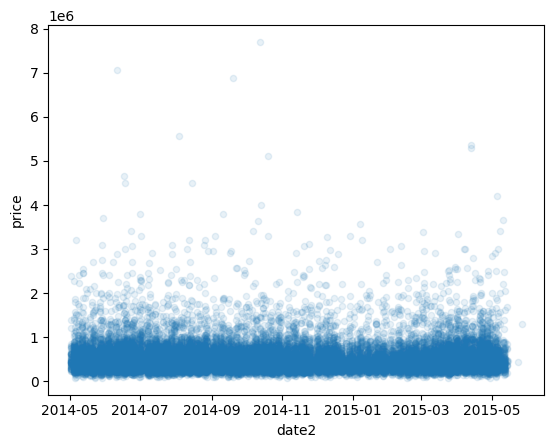

In [2]:

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv', dtype={'id': str})

# seperating id column to match major and minor.
housing['Major'] = housing['id'].str[:-4]
housing['Minor'] = housing['id'].str[-4:].astype(int).astype(str)
# now combining again, this is to get rid of trailing and leading zeros to elimate more duplicates
housing['more'] = housing['Major'].astype(str) + 'm' + housing['Minor'].astype(str)
# now inner joing county data set with training or prediction data set
df2 = pd.read_csv("https://raw.githubusercontent.com/1Ramirez7/Machine-Learning/refs/heads/main/housing_project/testcode/merged_data_5.csv", dtype={'more': str})
housing['more'] = housing['more'].astype(str)
df2['more'] = df2['more'].astype(str)
housing = housing.merge(df2, on='more', how='inner')


housing['date'] = pd.to_datetime(housing['date'], format='%Y%m%dT%H%M%S')
housing['days_since_april_1st'] = (housing['date'].dt.dayofyear + 365 - 91) % 365
housing['date2'] = (housing['date'].dt.date)
housing['month'] = (housing['date'].dt.month)
housing.plot.scatter("date2", "price", alpha = 0.1)

<Axes: xlabel='lat', ylabel='long'>

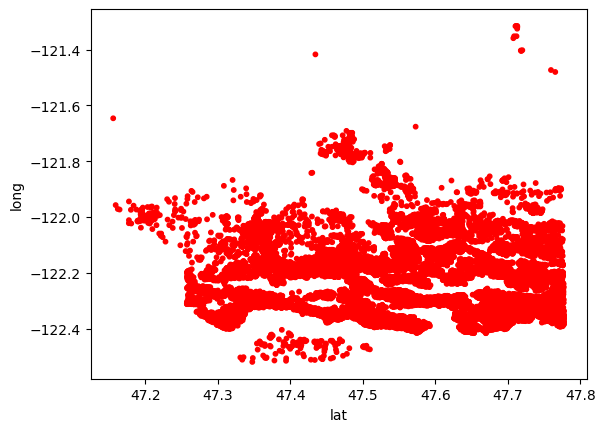

In [3]:
# housing.info()
priced = housing.copy()
priced["is_rich"] = housing["price"] > .8
rich_color= priced["is_rich"].map({True: "red", False: "blue"})
rich_a= priced["is_rich"].map({True: 1, False: .05})
# plt.figure(figsize=(12,8))
priced.plot.scatter(x="lat", y="long", c = rich_color , s = 10, alpha = rich_a)
# counts = priced["price"].value_counts()
# priced.plot.scatter(x="price", y= "zipcode", alpha = .1, c=rich_color)

In [4]:
# Load dataset
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv', dtype={'id': str})

# seperating id column to match major and minor. # adding king county data
housing['Major'] = housing['id'].str[:-4]
housing['Minor'] = housing['id'].str[-4:].astype(int).astype(str)
# now combining again, this is to get rid of trailing and leading zeros to elimate more duplicates
housing['more'] = housing['Major'].astype(str) + 'm' + housing['Minor'].astype(str)
# now inner joing county data set with training or prediction data set
df2 = pd.read_csv("https://raw.githubusercontent.com/1Ramirez7/Machine-Learning/refs/heads/main/housing_project/testcode/merged_data_5.csv", dtype={'more': str})
housing['more'] = housing['more'].astype(str)
df2['more'] = df2['more'].astype(str)
housing = housing.merge(df2, on='more', how='inner')
# end of adding king county data



# MinMaxScale manually
print(housing.sort_values("price").tail())
print(housing["price"].head())
#housing["price"] = np.log1p(housing["price"])
max_price = housing["price"].max()
min_price = housing["price"].min()
print(housing["price"].head())
housing["price"] = (housing["price"] - min_price) / (max_price - min_price)
print(housing["price"].head())

print("max", max_price)
print("min", min_price)
# y = np.log1p(housing["price"])  # Log transform target
y = housing["price"]  # Log transform target

X = fixData(housing)

              id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
371   8907500070  20150413T000000         5       5.00         8000     23985   
628   2470100110  20140804T000000         5       5.75         9200     35069   
5971  9208900037  20140919T000000         6       7.75         9890     31374   
5349  9808700762  20140611T000000         5       4.50        10040     37325   
8827  6762700020  20141013T000000         6       8.00        12050     27600   

      floors  waterfront  view  condition  ...  LakeSammamish  \
371      2.0           0     4          3  ...              0   
628      2.0           0     0          3  ...              0   
5971     2.0           0     4          3  ...              0   
5349     2.0           1     2          3  ...              0   
8827     2.5           0     3          4  ...              0   

      SmallLakeRiverCreek  OtherView  WfntLocation  WfntFootage  WfntBank  \
371                     0          0         

In [5]:
# DO NOT RUN MORE THAN ONCE, we want to keep these variables
bestClass = None
# best RMSE so far is ~127000
# 1700 n-estimators, 5 depth

In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


y_test = (y_test * (max_price - min_price) + min_price)
#y_test = np.expm1(y_test) # undoing log
# Create XGBoost regressor
for n in range(1750, 1751, 10):
    for d in range(6,7):
        n = 1742
        # d = 6
        model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", subsample=0.6,
                            n_estimators=n, max_depth=d, learning_rate=0.01, colsample_bytree=0.7)

        # Train model
        model.fit(X_train, y_train)

        # Make predictions on test set
        y_pred = model.predict(X_test)
        # print(y_pred)
        y_pred = (y_pred * (max_price - min_price) + min_price)
        # print(y_pred)
        #y_pred = np.expm1(y_pred) # undoing log
        # print(y_pred)

        # Undo your changes to price to get actual average price difference
        rmse = root_mean_squared_error(y_test, y_pred)
        # return from a log of cost to cost
        r2 = r2_score(y_test, y_pred)  # Compute R^2
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print("estimators: ",n,", depth: ",d)

        boostClass = BoostClass(r2, rmse, n, d, model)
        if (bestClass != None):
            if (boostClass.r2 > bestClass.r2):
                bestClass = boostClass
        else:
            bestClass = boostClass
print("Done!")
# Evaluate performance
print(bestClass.toString())

R² Score: 0.9283
RMSE: 94856.0726
estimators:  1742 , depth:  6
Done!
('r2: ', 0.928347911215165, ', rmse:', 94856.07259021031, ', n_estimators:', 1742, ', max depth:', 6)


In [7]:
# Load the holdout dataset
holdout_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv', dtype={'id': str})

# seperating id column to match major and minor. # adding king county data
holdout_data['Major'] = holdout_data['id'].str[:-4]
holdout_data['Minor'] = holdout_data['id'].str[-4:].astype(int).astype(str)
# now combining again, this is to get rid of trailing and leading zeros to elimate more duplicates
holdout_data['more'] = holdout_data['Major'].astype(str) + 'm' + holdout_data['Minor'].astype(str)
# now inner joing county data set with training or prediction data set
df2 = pd.read_csv("https://raw.githubusercontent.com/1Ramirez7/Machine-Learning/refs/heads/main/housing_project/testcode/merged_data_5.csv", dtype={'more': str})
holdout_data['more'] = holdout_data['more'].astype(str)
df2['more'] = df2['more'].astype(str)
holdout_data = holdout_data.merge(df2, on='more', how='inner')
# end of adding king county data




X_holdout = fixData(holdout_data)

# Predict using the trained model
y_holdout_pred = model.predict(X_holdout)

# Convert predictions back to original scale
y_holdout_pred_original = (y_holdout_pred * (max_price - min_price) + min_price)
#y_holdout_pred_original = np.expm1(y_holdout_pred_original) # undoing log


# Create DataFrame with correct format
predictions_df = pd.DataFrame({"price": y_holdout_pred_original})


In [8]:

# Save in the required format
team_name = "team8"  # Replace with your actual team name
filename = f"{team_name}-module3-predictions.csv"
predictions_df.to_csv(filename, index=False)

print(f"Predictions saved as {filename}")

Predictions saved as team8-module3-predictions.csv


In [9]:
#Take the predictions on the holdout data set and compare them to the actual prices found in this file
actual_df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/refs/heads/master/data/housing_holdout_test_mini_answers.csv")
rmse = root_mean_squared_error(actual_df, predictions_df)
r2 = r2_score(actual_df, predictions_df)
print("RMSE: ", rmse, "| r2: ", r2)

RMSE:  82726.82634197199 | r2:  0.9162401010159864


In [10]:
# had to code to read in county data

graphing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv', dtype={'id': str})

# seperating id column to match major and minor. # adding king county data
graphing['Major'] = graphing['id'].str[:-4]
graphing['Minor'] = graphing['id'].str[-4:].astype(int).astype(str)
# now combining again, this is to get rid of trailing and leading zeros to elimate more duplicates
graphing['more'] = graphing['Major'].astype(str) + 'm' + graphing['Minor'].astype(str)
# now inner joing county data set with training or prediction data set
df2 = pd.read_csv("https://raw.githubusercontent.com/1Ramirez7/Machine-Learning/refs/heads/main/housing_project/testcode/merged_data_5.csv", dtype={'more': str})
graphing['more'] = graphing['more'].astype(str)
df2['more'] = df2['more'].astype(str)
graphing = graphing.merge(df2, on='more', how='inner')
# end of adding king county data



graphing = fixData(graphing, False)

scaler = MinMaxScaler((0,1))
alpha_shade = scaler.fit_transform(graphing[["price"]])

In [11]:
bestClass = None
holdBestClass = None

# added code to read in the king county data. 
holdout_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv', dtype={'id': str})

# seperating id column to match major and minor. # adding king county data
holdout_data['Major'] = holdout_data['id'].str[:-4]
holdout_data['Minor'] = holdout_data['id'].str[-4:].astype(int).astype(str)
# now combining again, this is to get rid of trailing and leading zeros to elimate more duplicates
holdout_data['more'] = holdout_data['Major'].astype(str) + 'm' + holdout_data['Minor'].astype(str)
# now inner joing county data set with training or prediction data set
df2 = pd.read_csv("https://raw.githubusercontent.com/1Ramirez7/Machine-Learning/refs/heads/main/housing_project/testcode/merged_data_5.csv", dtype={'more': str})
holdout_data['more'] = holdout_data['more'].astype(str)
df2['more'] = df2['more'].astype(str)
holdout_data = holdout_data.merge(df2, on='more', how='inner')
# end of adding king county data

actual_df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/refs/heads/master/data/housing_holdout_test_mini_answers.csv")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


y_test = (y_test * (max_price - min_price) + min_price)
#y_test = np.expm1(y_test) # undoing log
# Create XGBoost regressor
for n in range(1720, 1721, 100):
    for d in range(5,7):
        # n = 1742
        # d = 6
        model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", subsample=0.6,
                            n_estimators=n, max_depth=d, learning_rate=0.05, colsample_bytree=0.7)

        # Train model
        model.fit(X_train, y_train)

        # Make predictions on test set
        y_pred = model.predict(X_test)
        # print(y_pred)
        y_pred = (y_pred * (max_price - min_price) + min_price)
        # print(y_pred)
        #y_pred = np.expm1(y_pred) # undoing log
        # print(y_pred)

        # Undo your changes to price to get actual average price difference
        rmse = root_mean_squared_error(y_test, y_pred)
        # return from a log of cost to cost
        r2 = r2_score(y_test, y_pred)  # Compute R^2
        print(f"\nTEST DATA: RMSE: {rmse:.1f}| r2: {r2:.4f}")
        print("estimators: ",n,", depth: ",d)

        

        X_holdout = fixData(holdout_data)

        # Predict using the trained model
        y_holdout_pred = model.predict(X_holdout)

        # Convert predictions back to original scale
        y_holdout_pred_original = (y_holdout_pred * (max_price - min_price) + min_price)
        #y_holdout_pred_original = np.expm1(y_holdout_pred_original) # undoing log


        # Create DataFrame with correct format
        predictions_df = pd.DataFrame({"price": y_holdout_pred_original})

        rmse_hold = root_mean_squared_error(actual_df, predictions_df)
        r2_hold = r2_score(actual_df, predictions_df)
        print(f"HOLDOUT: RMSE: {rmse_hold:.1f} | r2: {r2_hold:.4f}")




        boostClass = BoostClass(r2, rmse , n, d, model)
        holdClass = BoostClass((r2_hold), (rmse_hold), n, d, model)
        if (bestClass != None):
            if (boostClass.r2 + holdClass.r2 > bestClass.r2 + holdBestClass.r2):
                bestClass = boostClass
                holdBestClass = holdClass
        else:
            bestClass = boostClass
            holdBestClass = holdClass
print("Done!")
# Evaluate performance
print("TEST-DATA: ", bestClass.toString())
print("HOLDOUT:   ", holdClass.toString())


TEST DATA: RMSE: 94949.7| r2: 0.9282
estimators:  1720 , depth:  5
HOLDOUT: RMSE: 91918.4 | r2: 0.8966

TEST DATA: RMSE: 96278.6| r2: 0.9262
estimators:  1720 , depth:  6
HOLDOUT: RMSE: 87243.9 | r2: 0.9068
Done!
TEST-DATA:  ('r2: ', 0.9261827381294365, ', rmse:', 96278.5802411987, ', n_estimators:', 1720, ', max depth:', 6)
HOLDOUT:    ('r2: ', 0.9068434878575955, ', rmse:', 87243.86583548323, ', n_estimators:', 1720, ', max depth:', 6)


IndexError: index 34 is out of bounds for axis 1 with size 34

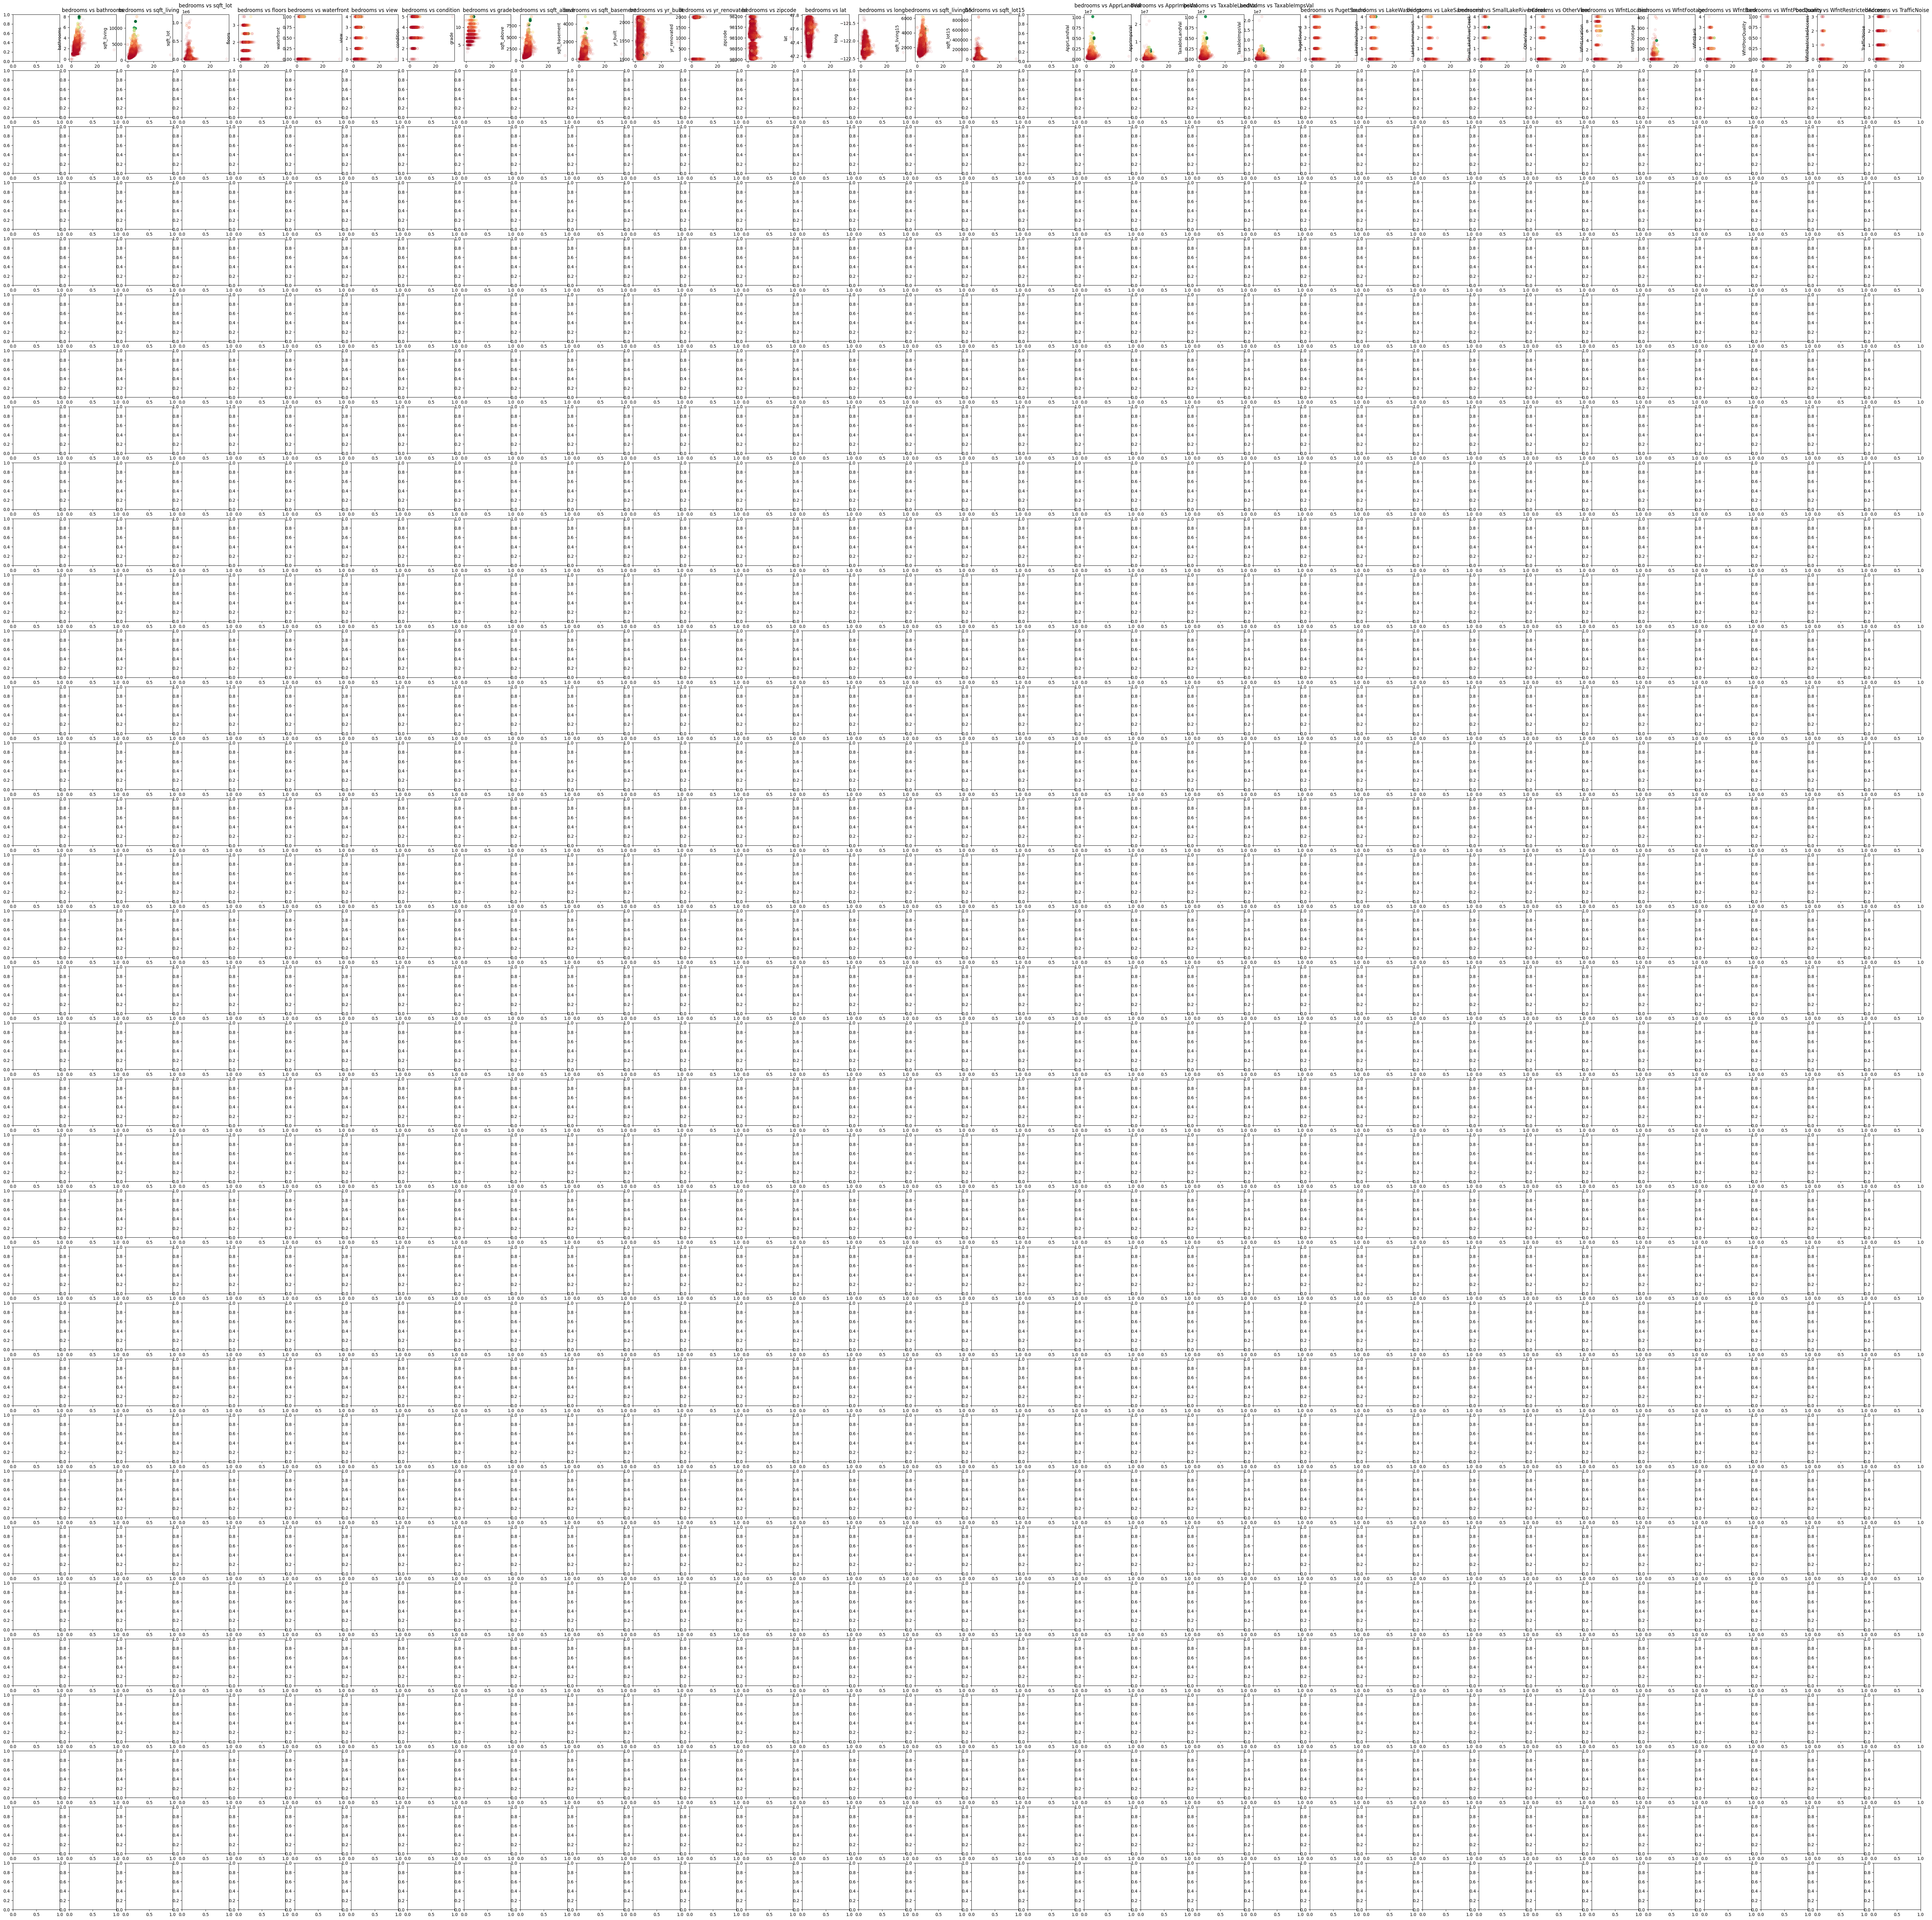

In [12]:
wid = len(graphing.columns) - 1
fig, axes = plt.subplots(wid, wid, figsize=(80,80))
for i, column in enumerate(graphing.columns):
    for j, column2 in enumerate(graphing.columns):
        if i < j and column2 != "price":
            ax= axes[i,j]
            ax.scatter(graphing[column], graphing[column2], alpha=alpha_shade, c = graphing["price"], cmap='RdYlGn')
            ax.set_xlabel(column)
            ax.set_ylabel(column2)
            ax.set_title(f'{column} vs {column2}')

plt.tight_layout(pad = 0.0)
plt.show()
